In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme() # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#5F6372', '#79A8A4', '#B2AD8F', '#92A186', '#AD8082']
blue = '#5F6372'
turqoise = '#79A8A4'
light_green = '#B2AD8F'
green = '#92A186'
pink = '#AD8082'
muted_colors = sns.set_palette(sns.color_palette(colors))

# configuring fonts for plotting
font = FontProperties()
font.set_family('avenir')
font.set_name('Big Caslon')
font.set_style('normal')
font.set_size('xx-large')


%matplotlib inline  

In [3]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from BE_plotting import*
#from RR_lyrae_params import*
from blazhko_analysis import*

## Importing data

The first step is to import the `LINEAR` and `ZTF` data, as well as the data calculated in the previous notebook.

In [4]:
#| code-fold: false
# DATA
dataLINEAR = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library
end = 'FINAL_FINAL_complete_revised'

# DATA from previous notebook
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
lc_select = pd.read_csv('../outputs/LC_ANALYSIS_complete_selectabove250.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

In [5]:
lc_analysis = lc_analysis.loc[lc_analysis['NdataZTF']>40]
lc_analysis = lc_analysis.reset_index(drop=True)
print(lc_analysis.shape)
lc_analysis.head()

(1239, 38)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,10030349,0.545073,0.545074,0.545074,1.000002,255,0.076910,8.7,2.1,0.071804,...,1.8346,1.9187,11.8963,0.0177,5.5569,0.10,0.00000,NaN,NaN,NaN
1,10040133,0.610543,0.610549,0.610546,1.000010,257,0.093696,0.9,0.9,0.093572,...,1.6379,1.6415,277.7778,0.0092,12.0512,0.11,0.00001,NaN,NaN,NaN
2,1004849,0.458463,0.458467,0.458465,1.000009,607,0.066321,6.5,1.3,0.068260,...,2.1811,2.2704,11.2020,0.0611,5.1960,0.27,0.00001,NaN,NaN,NaN
3,1005497,0.653607,0.653605,0.653606,0.999997,607,0.073102,2.1,1.1,0.073174,...,1.5300,1.5490,52.6316,0.0836,7.2669,0.09,0.00000,NaN,NaN,NaN
4,10064356,0.628286,0.628279,0.628283,0.999989,291,0.107486,2.0,1.0,0.112746,...,1.5917,1.6454,18.6254,0.0393,10.8542,0.14,0.00001,NaN,NaN,NaN


### Plotting a light curve as an example

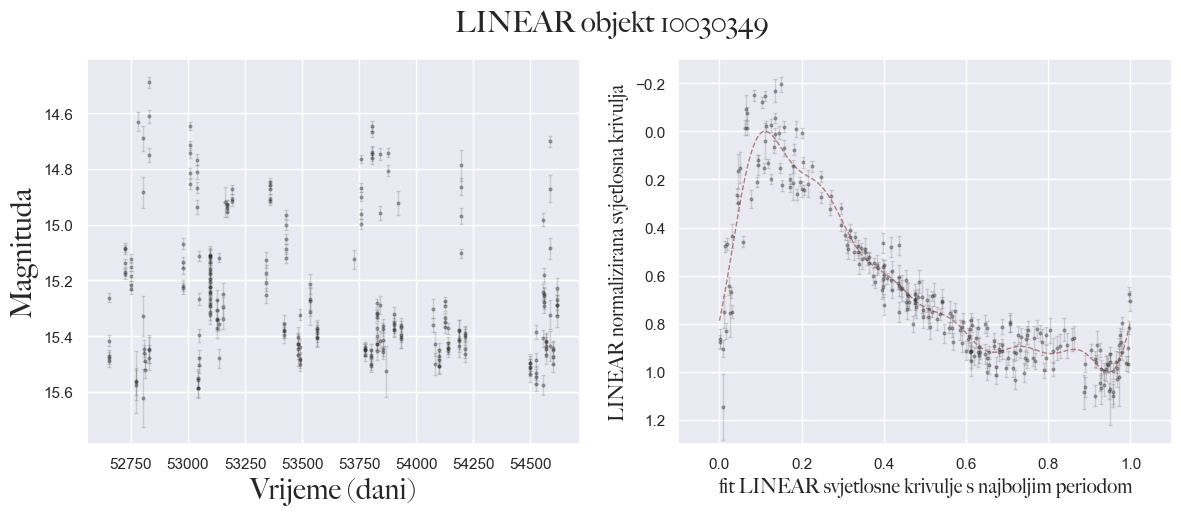

In [6]:
order = 0
LiNeAr_ids = lc_analysis['LINEAR id'].to_numpy()
total_num = len(lc_analysis['LINEAR id'].to_numpy())
Lid = LiNeAr_ids[order]
lc_data_order = dataLINEAR.get_light_curve(Lid)
time, mag, magerr = lc_data_order.T
for n, j in enumerate(fits):
    if j[0]==Lid:
        break

L1 = fits[n][1][0]

fig, ax = plt.subplots(1,2, figsize=(14,5))   
#fig.suptitle('STAR '+str(order+1)+' from '+str(total_num), fontsize=30, fontproperties=font)
fig.set_facecolor('white')

#--------
ax[0].errorbar(time, mag, magerr, fmt='.k', ecolor='gray',lw=1, ms=4, capsize=1.5,alpha=0.3)
ax[0].set_xlabel('Vrijeme (dani)',fontproperties=font)
ax[0].set_ylabel('Magnituda', fontproperties=font)
fig.suptitle('LINEAR objekt {0}'.format(Lid), fontproperties=font)
ax[0].invert_yaxis()

# -----

ax[1].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom', fontproperties=font, fontsize=14)
ax[1].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax[1].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# fit for Plinear
ax[1].plot(L1['modelPhaseGrid'], L1['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

plt.savefig("../images/primjer_svkrivulje_sve.png", dpi=600)

In [7]:
lc_analysis.head()

,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_rms,L_chi2dof,L_chi2dofR,Lmean_rms,...,MainPeakZ,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score
0,10030349,0.545073,0.545074,0.545074,1.000002,255,0.076910,8.7,2.1,0.071804,...,1.8346,1.9187,11.8963,0.0177,5.5569,0.10,0.00000,NaN,NaN,NaN
1,10040133,0.610543,0.610549,0.610546,1.000010,257,0.093696,0.9,0.9,0.093572,...,1.6379,1.6415,277.7778,0.0092,12.0512,0.11,0.00001,NaN,NaN,NaN
2,1004849,0.458463,0.458467,0.458465,1.000009,607,0.066321,6.5,1.3,0.068260,...,2.1811,2.2704,11.2020,0.0611,5.1960,0.27,0.00001,NaN,NaN,NaN
3,1005497,0.653607,0.653605,0.653606,0.999997,607,0.073102,2.1,1.1,0.073174,...,1.5300,1.5490,52.6316,0.0836,7.2669,0.09,0.00000,NaN,NaN,NaN
4,10064356,0.628286,0.628279,0.628283,0.999989,291,0.107486,2.0,1.0,0.112746,...,1.5917,1.6454,18.6254,0.0393,10.8542,0.14,0.00001,NaN,NaN,NaN


In [ ]:
order1 = 1
order2 = 2
LiNeAr_ids = lc_analysis['LINEAR id'].to_numpy()
total_num = len(lc_analysis['LINEAR id'].to_numpy())
Lid1 = LiNeAr_ids[order1]
Lid2 = LiNeAr_ids[order2]
for n, j in enumerate(fits):
    if j[0]==Lid1:
        L1 = fits[n][1][0]
        break
    if j[0]==Lid2:
        L2 = fits[n][1][0]
        break

fig, ax = plt.subplots(1,2, figsize=(14,5)) 
fig.suptitle('LINEAR objekti {0} i {1}'.format(Lid1, Lid2), fontproperties=font)
fig.set_facecolor('white')

#--------
ax[0].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom RRAB', fontproperties=font, fontsize=14)
ax[0].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[0].set_xlim(-0.1, 1.1)
ax[0].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax[0].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# ft for Plinear
ax[0].plot(L1['modelPhaseGrid'], L1['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

# -----
ax[1].set_xlabel('fit LINEAR svjetlosne krivulje s najboljim periodom RRC', fontproperties=font, fontsize=14)
ax[1].set_ylabel('LINEAR normalizirana svjetlosna krivulja', fontproperties=font, fontsize=14)
ax[1].set_xlim(-0.1, 1.1)
ax[1].set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
ax[1].errorbar(xx, yy, zz, fmt='.k', ecolor='gray', lw=1, ms=4, capsize=1.5, alpha=0.3)
# fit for Plinear
ax[1].plot(L2['modelPhaseGrid'], L2['modTemplate'], pink, markeredgecolor=pink, lw=1, fillstyle='top', linestyle='dashed')

plt.savefig("../images/rrabirrcprimjer.png", dpi=600)

# Determination of BE candidates

(write up entire explanation of the algorithm)

In [8]:
blazhko_can = pd.DataFrame(())
blazhko_can = blazhko_determine(lc_analysis, blazhko_can)
blazhko_can.to_csv("../outputs/blazhko_can"+end+".csv", index=False)

In [9]:
blazhko_can.shape

(293, 39)

In [49]:
blazhko_can_select = pd.DataFrame(())
blazhko_can_select = blazhko_determine(lc_select, blazhko_can_select)
blazhko_can.to_csv("../outputs/blazhko_can_select"+end+".csv", index=False)

In [50]:
blazhko_can_select.shape

(3, 40)

# Determining vallidity of BE candidates

In order to make visual interpretation easier and more robust, we are dividing our BE candidates into smaller tables. The categories are:
- LINEAR periodogram parameter satisfied
- ZTF periodogram parameter satisfied
- Chi2 parameter satisfied
    - ZTF Chi2 parameter
    - LINEAR Chi2 parameter

The last three are based on the `ChiType` for determining LINEAR or ZTF parameter satisfaction. The periodogram parameter is determined by the `IndicatorType` column.

# Visual inspection of every category

In [10]:
BE_candidates_ztf_per = category_analysis(blazhko_can, 'IndicatorType', 'Z', fits, periodogr, ztf_data, dataLINEAR, 'ztf_periodogram')

This dataset has 127 stars.


In [11]:
BE_candidates_linear_per = category_analysis(blazhko_can, 'IndicatorType', 'L', fits, periodogr, ztf_data, dataLINEAR, 'linear_periodogram')

This dataset has 66 stars.


In [12]:
BE_candidates_ztf_chi = category_analysis(blazhko_can, 'ChiType', 'Z', fits, periodogr, ztf_data, dataLINEAR, 'ztf_chi')

This dataset has 65 stars.


In [13]:
BE_candidates_linear_chi = category_analysis(blazhko_can, 'ChiType', 'L', fits, periodogr, ztf_data, dataLINEAR, 'ztf_chi')

This dataset has 16 stars.
